In [20]:
from sage.all import *
import matplotlib.pyplot as plt

GRAPHVISUALS = True

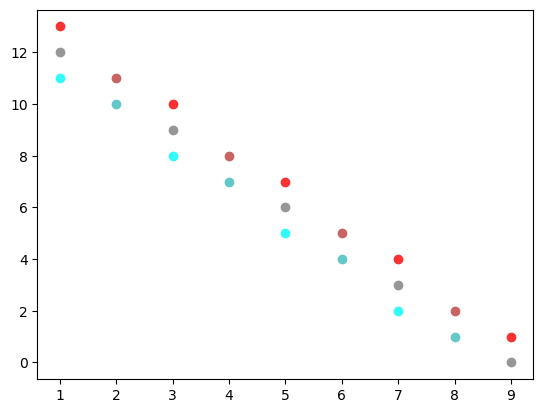

In [21]:
import pandas as pd
pd.options.display.max_columns = None
pd.set_option('display.max_rows', int(500))
pd.options.display.width = int(500)
pd.options.display.max_colwidth = int(500)

#helper function needed later
def partitions(n, I=1):
    yield (n,)
    for i in range(I, n//2 + 1):
        for p in partitions(n-i, i):
            yield (i,) + p

# the upper bound of excess analysis considered
MAX_EXCESS = 4

gn_table = []
fig = plt.figure()
ax = fig.add_subplot()
for excess in range(0,MAX_EXCESS+1):
    ax.name = 'Excess '+str(excess)
    gn_table.append([])
    for g in range(1,floor((excess+22)/3+1)+1):
        if (excess+22-3*g+3)%2 == 0:
            n = (excess+22-3*g+3)/2
            gn_table[excess].append((g,n))
    ax.scatter(*zip(*gn_table[excess]),c='#'+str(hex(int(50+excess*200/MAX_EXCESS))[2:])+str(hex(int(50+(MAX_EXCESS-excess)*200/MAX_EXCESS))[2:])+str(hex(int(50+(MAX_EXCESS-excess)*200/MAX_EXCESS))[2:]))
plt.show()

In [22]:
# wrapper object for the connected components of the blow up at the special vertex
class UnmarkedBlowUpComponent:
    def __init__(self,graph,unmarked=0,n_add=0,vertices=0,crossed=False):
        self.nameID='-1'
        self.ID='-1'
        self.graph = graph
        self.crossed = crossed  #either boolean false, or equals the tuple of the crossed edge in the graph
        self.crossType = 'None'
        if self.crossed:
            if isinstance(self.crossed[0],str) or isinstance(self.crossed[1],str): self.crossType = 'A' #weight 13 special vertex
            else: self.crossType = 'B'  #weight 11 special vertex
    
        self.unmarked = unmarked  #number of unmarked hairs
        self.n_add = n_add  #  number of hairs from the original graph which end up in this component
        self.vertices = vertices #internal, and counting the potential crossed edge as two !
        if unmarked+n_add+vertices!=graph.order(): print("BlowUpComponent FED WRONG VERTEX COUNT")
        self.edges = graph.size()-unmarked-n_add if vertices!=0 else 0 #internal, but counting the potential crossed edge !
        self.v_add = vertices-int((self.crossed!=False) and (self.crossed[0]!=self.crossed[1]))  #vertex contribution when glued to the special vertex
        self.e_add = self.edges+unmarked-int(self.crossed!=False)    #edges contribution when glued to the special vertex

        self.n = unmarked+n_add
        self.is_stable = True
        self.stability = 0
        for v in range(vertices):
            self.stability += graph.degree(v)-2
            if graph.degree(v)<3: self.is_stable=False
        if not self.is_stable: print("BlowUpComponent NOT STABLE")
        self.g = (self.stability-unmarked-n_add+2)/2      #total genus of the hairy graph
        self.g_add = self.g+unmarked-1   #genus contribution when glued to the special vertex

        if GRAPHVISUALS:
            self.partition = {'vertices': [x for x in range(self.vertices)], 'unmarked':['u'+str(x) for x in range(self.unmarked)], 'n_add':['n'+str(x) for x in range(self.n_add)]}
            self.vertex_position = {}
            DX = 1/(self.unmarked)
            X = DX/2
            Y = 0
            for i in range(self.unmarked):
                self.vertex_position['u'+str(i)] = [X,Y]
                X+=DX

            if self.n_add!=0:
                DX = 1/self.n_add
                X=DX/2
                Y=1
                for i in range(self.n_add):
                    self.vertex_position['n'+str(i)] = [X,Y]
                    X+=DX
            if self.vertices == 1 or self.vertices==2:
                DX = 1/self.vertices
                X=DX/2
                Y=0.5
                for i in range(self.vertices):
                    self.vertex_position[i] = [X,Y]
                    X+=DX
            elif self.vertices>=3:
                DT = 2*math.pi/self.vertices
                T = -math.pi/2-DT/2
                for i in range(self.vertices):
                    self.vertex_position[i] = [0.5+cos(T)*0.45,0.5+sin(T)*0.3]
                    T-=DT

    def label_hairs_uniquely(self):
        for x in range(self.n_add):
            for edge in self.graph.edges(vertices=['n'+str(x)],sort=False):
                self.graph.set_edge_label(edge[0],edge[1],'n'+str(x))
    def unlabel_hairs(self):
        for x in range(self.n_add):
            for edge in self.graph.edges(vertices=['n'+str(x)],sort=False):
                self.graph.set_edge_label(edge[0],edge[1],'n')

    def __str__(self, short=True):
        if short:
            name = ""
            if self.vertices==0:
                if self.unmarked==1 and self.n_add==1: name="|"
                elif self.unmarked==2: name="_"
                else: print("UnmarkedBlowUpComponent STRING RAN OUT CASES") 
            elif self.crossed and self.crossed[0]==self.crossed[1]:
                 name = 'uIrr'
            else:
                for x in range(self.unmarked): name+='u'
                if self.crossType=='A': name+='CR'
                for x in range(self.vertices): name+='v'
                if self.crossType=='B': name+='CR'
                for x in range(self.n_add): name+='j'
                if self.vertices!=1: name += str(self.nameID)
            return name
        else:
            string = f"UnmarkedBlowUpComponent; ID: {self.ID}  name: {self.__str__()}  unmarked,n_add: {str(self.unmarked)}, {str(self.n_add)}   V: {str(self.vertices)}   E: {str(self.edges)}  g: {str(self.g)}"
            if self.crossed:
                string+="  cross: "+str(self.crossed)
                if self.crossed[0]==self.crossed[1]: string+="  irreducible "
            return string
        
    def show(self,name=False):
        if name: print(self.__str__(False))
        if GRAPHVISUALS:
            if not self.crossed:
                self.graph.graphplot(edge_labels=True, edge_labels_background='#FF000000', pos=self.vertex_position,vertex_colors={'lightgrey':self.partition['vertices'], 'sandybrown':self.partition['unmarked'], 'lime':self.partition['n_add']}).show()
            else:
                self.graph.graphplot(edge_labels=True, edge_labels_background='#FF000000', pos=self.vertex_position, edge_colors={'red':[self.crossed]},vertex_colors={'lightgrey':self.partition['vertices'], 'sandybrown':self.partition['unmarked'], 'lime':self.partition['n_add']}).show()

In [23]:
# wrapper object for the connected components of the blow up at the special vertex
class BlowUpComponent:
    def __init__(self,graph,eps=0,ome=0, n_add=0,vertices=0,crossed=False):
        self.nameID='-1'
        self.ID='-1'
        self.graph = graph
        self.crossed = crossed  #either boolean false, or equals the tuple of the crossed edge in the graph
        self.crossType = 'None'
        if self.crossed:
            if isinstance(self.crossed[0],str) or isinstance(self.crossed[1],str): self.crossType = 'A' #weight 13 special vertex
            else: self.crossType = 'B'  #weight 11 special vertex
        
        self.eps = eps      #  number of epsilon hairs   
        self.ome = ome      #  number of omega hairs   
        self.n_add = n_add  #  number of hairs from the original graph which end up in this component
        self.vertices = vertices #internal, and counting the potential crossed edge as two !
        if eps+ome+n_add+vertices!=graph.order(): print("BlowUpComponent FED WRONG VERTEX COUNT")
        self.edges = graph.size()-eps-ome-n_add if vertices!=0 else 0 #internal, but counting the potential crossed edge !
        self.v_add = vertices-int((self.crossed!=False) and (self.crossed[0]!=self.crossed[1]))  #vertex contribution when glued to the special vertex
        self.e_add = self.edges+eps+ome-int(self.crossed!=False)    #edges contribution when glued to the special vertex

        self.n = eps+ome+n_add
        self.is_stable = True
        self.stability = 0
        for v in range(vertices):
            self.stability += graph.degree(v)-2
            if graph.degree(v)<3: self.is_stable=False
        if not self.is_stable: print("BlowUpComponent NOT STABLE")
        self.g = (self.stability-eps-ome-n_add+2)/2      #total genus of the hairy graph
        self.excess = 3*self.g-3+3*eps+ome+2*n_add   # excess of blown up components
        self.g_add = self.g+eps+ome-1   #genus contribution when glued to the special vertex

        self.A3case = False
        self.irreducible = False  # relatedness to the irreducible crossed graph o--crossed--v--loop
        self.irreducible_neighbour = None #edge tuple of the omega hair neighbour in case it is irreducible
        self.irreducibly_null = False #omega tripod with crossed edge
        if self.crossType=='A':
            v = self.crossed[0]
            if isinstance(self.crossed[0],str): v = self.crossed[1]
            if graph.degree(v)>3: self.A3case=True
            else:
                count=0
                for edge in graph.edges(vertices=[v],labels=True,sort=False): 
                    if edge[2]=='o':
                        self.irreducible_neighbour = edge
                        count+=1
                self.irreducibly_null = (count==2)
                if count!=0:
                    self.irreducible=True

        self.B1case = False
        if self.crossType=='B':
            if self.crossed[0]!=self.crossed[1]: self.B1case =True
            else:
                for edge in self.graph.edges(vertices=[self.crossed[0]],sort=False,labels=True):
                    if edge[2]!='CROSS': self.irreducible_neighbour=edge
        
        #the final blown up graph has an odd symmetry if and only if it has a component with an odd symmetry or it has at least two isomorphic components with odd number of internal edges + epsilon hairs
        self.odd_component = (self.crossed==False and self.n_add==0 and (self.edges+self.eps)%2==1)
        self.check_oddsymmetry()

        if GRAPHVISUALS:
            self.partition = {'vertices': [x for x in range(self.vertices)], 'eps':['e'+str(x) for x in range(self.eps)],'ome':['o'+str(x) for x in range(self.ome)], 'n_add':['n'+str(x) for x in range(self.n_add)]}
            self.vertex_position = {}
            DX = 1/(self.eps+self.ome)
            X = DX/2
            Y = 0
            for i in range(self.ome):
                self.vertex_position['o'+str(i)] = [X,Y]
                X+=DX
            for i in range(self.eps):
                self.vertex_position['e'+str(i)] = [X,Y]
                X+=DX

            if self.n_add!=0:
                DX = 1/self.n_add
                X=DX/2
                Y=1
                for i in range(self.n_add):
                    self.vertex_position['n'+str(i)] = [X,Y]
                    X+=DX
            if self.vertices == 1 or self.vertices==2:
                DX = 1/self.vertices
                X=DX/2
                Y=0.5
                for i in range(self.vertices):
                    self.vertex_position[i] = [X,Y]
                    X+=DX
            elif self.vertices>=3:
                DT = 2*math.pi/self.vertices
                T = -math.pi/2-DT/2
                for i in range(self.vertices):
                    self.vertex_position[i] = [0.5+cos(T)*0.45,0.5+sin(T)*0.3]
                    T-=DT

    def label_hairs_uniquely(self):
        for x in range(self.n_add):
            for edge in self.graph.edges(vertices=['n'+str(x)],sort=False):
                self.graph.set_edge_label(edge[0],edge[1],'n'+str(x))
    def unlabel_hairs(self):
        for x in range(self.n_add):
            for edge in self.graph.edges(vertices=['n'+str(x)],sort=False):
                self.graph.set_edge_label(edge[0],edge[1],'n')
    def check_oddsymmetry(self):
        #the symmetry automorphisms must fix the n_add hairs, so relabel their edges from the anonymous 'n' to 'nx', where 1≤x≤n_add is the index of the hair
        self.label_hairs_uniquely()
        #the blow up component has an odd symmetry if and only if there is a generator of the automorphism group with odd sign of permutation on the internal edges + epsilon hairs
        autom = self.graph.automorphism_group(edge_labels=True)
        self.odd = False
        self.odd_symmetry = None
        for f in autom.gens():
            sign_count = 0
            orbits = []
            for edge in self.graph.edges(sort=False,labels=True):
                if (edge[2]==None or edge[2]=='e') and not any(({edge[0],edge[1]} in orbit) for orbit in orbits):
                    orbits.append([{edge[0],edge[1]}])
                    edge2 = (edge[0],edge[1])
                    while {f(edge2[0]),f(edge2[1])}!={edge[0],edge[1]}:
                        edge2 = (f(edge2[0]),f(edge2[1]))
                        sign_count+=1
                        orbits[len(orbits)-1].append({edge2[0],edge2[1]})                    
            if sign_count%2!=0:
                self.odd = True
                self.odd_symmetry = f
                break
        #relabel to original state the n_add hairs
        self.unlabel_hairs()

    def __str__(self, short=True):
        if short:
            name = ""
            if self.vertices==0:
                if self.ome==1 and self.n_add==1: name="|"
                elif self.ome==1 and self.eps==1: name=",_"
                elif self.eps==1 and self.n_add==1: name="!"
                elif self.eps==2: name="._"            
            elif self.crossed and self.crossed[0]==self.crossed[1]:
                if self.irreducible_neighbour[2]=='o': name = 'oIrr'
                elif self.irreducible_neighbour[2]=='e': name = 'eIrr'
            else:
                for x in range(self.ome): name+='o'
                if self.crossType=='A': name+='CR'
                for x in range(self.eps): name+='e'
                for x in range(self.vertices): name+='v'
                if self.crossType=='B': name+='CR'
                for x in range(self.n_add): name+='j'
                if self.vertices!=1: name += str(self.nameID)
            return name
        else:
            string = f"BlowUpComponent; ID: {self.ID}  name: {self.__str__()}  excess: {str(self.excess)}  eps,ome,n_add: {str(self.eps)}, {str(self.ome)}, {str(self.n_add)}   V: {str(self.vertices)}   E: {str(self.edges)}  g: {str(self.g)}"
            if self.crossed:
                string+="  cross: "+str(self.crossed)
                if self.irreducible or self.crossed[0]==self.crossed[1]: string+="  irr. neighbour: "+str(self.irreducible_neighbour)
            if self.odd: string+="  odd symmetry: "+str(self.odd_symmetry)
            if self.odd_component: string+="  , has odd edges"
            return string
        
    def show(self,name=False):
        if name: print(self.__str__(False))
        if GRAPHVISUALS:
            if not self.crossed:
                self.graph.graphplot(edge_labels=True, edge_labels_background='#FF000000', pos=self.vertex_position,vertex_colors={'lightgrey':self.partition['vertices'], 'gold':self.partition['eps'],'cyan':self.partition['ome'], 'lime':self.partition['n_add']}).show()
            else:
                self.graph.graphplot(edge_labels=True, edge_labels_background='#FF000000', pos=self.vertex_position, edge_colors={'red':[self.crossed]},vertex_colors={'lightgrey':self.partition['vertices'], 'gold':self.partition['eps'],'cyan':self.partition['ome'], 'lime':self.partition['n_add']}).show()

In [24]:
#generator function for unmarked blow up components
def generate_UnmarkedBlowUpComponents(unmarked,n_add,vertices,checkgenus=None):
    pool_skeletons = graphs.nauty_geng(str(vertices)+" -c")
    pool_UnmarkedComponents = []
    pool_UnmarkedCrossedInt = []
    pool_UnmarkedCrossedOme = []

    n_hairs = Subsets(list(range(vertices))*n_add,n_add,submultiset=True) #all multisubsets of the vertices with size n_add
    unm_hairs = Subsets(list(range(vertices))*unmarked,unmarked,submultiset=True) #all multisubsets of the vertices with size unmarked
    for S in pool_skeletons:
        #skip skeletons with wrong genus, as they will be considered for another value of the excess
        g = sum([S.degree(v)-2 for v in range(vertices)])/2+1
        if checkgenus!=None and checkgenus!=g: continue

        pool_UnmarkedComponents.append([])
        pool_UnmarkedCrossedInt.append([])
        pool_UnmarkedCrossedOme.append([])
        for f_unm in unm_hairs:
            for f_n in n_hairs:
                S_hairs = copy(S)
                count=0
                for v in f_unm:
                    S_hairs.add_vertex('u'+str(count))
                    S_hairs.add_edge('u'+str(count),v,'u')
                    count += 1
                count=0
                for v in f_n:
                    S_hairs.add_vertex('n'+str(count))
                    S_hairs.add_edge('n'+str(count),v,'n')
                    count += 1
                #at least trivalent vertices
                if all(S_hairs.degree(v)>=3 for v in range(vertices)):
                    #up to isomorphism of hairy graphs with labeled hairs. It is sufficient to check isomorphism with previous graphs which have the same skeleton S
                    if not any((G.graph.is_isomorphic(S_hairs, edge_labels=True)) for G in pool_UnmarkedComponents[len(pool_UnmarkedComponents)-1]):
                        comp = UnmarkedBlowUpComponent(S_hairs,unmarked,n_add,vertices)
                        pool_UnmarkedComponents[len(pool_UnmarkedComponents)-1].append(comp)
                        #crossed at internal edge
                        for edge in S.edges(sort=False):
                            S_crossed = copy(S_hairs)
                            S_crossed.set_edge_label(edge[0],edge[1],'CROSS')
                            #up to isomorphism of hairy graphs with labeled hairs and crossed edge
                            if not any((G.graph.is_isomorphic(S_crossed, edge_labels=True)) for G in pool_UnmarkedCrossedInt[len(pool_UnmarkedCrossedInt)-1]):
                                comp = UnmarkedBlowUpComponent(S_crossed,unmarked,n_add,vertices,crossed=(edge[0],edge[1]))
                                pool_UnmarkedCrossedInt[len(pool_UnmarkedCrossedInt)-1].append(comp)

                        #crossed at omega hair. Up to isomorphism, there is only one way of crossing for every internal vertex with an omega hair
                            visited = [] #visited vertices
                            for v in f_unm:
                                if v in visited: continue
                                visited.append(v)
                                for edge in S_hairs.edges(vertices=[v],sort=False,labels=True):
                                    if edge[2]=='u':
                                        S_crossed = copy(S_hairs)
                                        S_crossed.set_edge_label(edge[0],edge[1],'CROSS')
                                        #up to isomorphism of hairy graphs with labeled hairs and crossed edge
                                        if not any((G.graph.is_isomorphic(S_crossed, edge_labels=True)) for G in pool_UnmarkedCrossedOme[len(pool_UnmarkedCrossedOme)-1]):
                                            comp = UnmarkedBlowUpComponent(S_crossed,unmarked,n_add,vertices,crossed=(edge[0],edge[1]))
                                            pool_UnmarkedCrossedOme[len(pool_UnmarkedCrossedOme)-1].append(comp)
    #unwrap list of lists
    return [G for pool in pool_UnmarkedComponents for G in pool]+[G for pool in pool_UnmarkedCrossedInt for G in pool]+[G for pool in pool_UnmarkedCrossedOme for G in pool]

In [25]:
#generator function for blow up components
#Return a list of blowup components objects which contains all graphs with the following features:
# connected, with least trivalent (internal) vertices
# with eps+ome+n_add hairs partitioned in the three families by labeling their edges as 'e','o' or 'n'
# satisfying checkexcess==3(g-1)+3eps+ome+2n_add
# either:  simple
#    or:   simple and has a crossed omega hair
#    or:   has a crossed internal edge and is simple except possibly for having an additional edge parallel to the crossed edge   <---- STILL NEED TO IMPLEMENT !!!

# In excess ≤3, every case B graph with a multiple edge parallel to the crossed edge vanishes bc of odd symmetry, so we need not consider it.
# The remaining 6 graphs of interest (4 double legs, crossed omega hair with a loop at its end, the irreducible with epsilon hair) are added manually afterwards.
# At this level, the n_add hairs are not uniquely labeled because we care about blow up components up to isomorphisms that are allowed to permute them,
#   afterwards, we will relabel them uniquely in all possible ways that create non isomorphic blow up representations
def generate_blowup_components(eps,ome,n_add,vertices,checkgenus=None):
    pool_skeletons = graphs.nauty_geng(str(vertices)+" -c")
    pool_components = [] #uncrossed blow up components, for every skeleton graph
    pool_crossedInt= [] #crossed components at internal edge, for every skeleton
    pool_crossedOme= [] #crossed components at omega hair, for every skeleton

    pool_unmarkedcomponents = [] #uncrossed blow up components, for every skeleton graph
    pool_unmarkedcrossedInt= [] #crossed components at internal edge, for every skeleton
    pool_unmarkedcrossedOme= [] #crossed components at omega hair, for every skeleton
    
    eps_hairs = Subsets(list(range(vertices))*eps,eps,submultiset=True) #all multisubsets of the vertices with size eps
    ome_hairs = Subsets(list(range(vertices))*ome,ome,submultiset=True) #all multisubsets of the vertices with size ome
    n_hairs = Subsets(list(range(vertices))*n_add,n_add,submultiset=True) #all multisubsets of the vertices with size n_add
    #n_hairs = FiniteSetMaps(n_add, vertices) #all functions from {0,1,...,n_add-1} to the vertices
    for S in pool_skeletons:
        #skip skeletons with wrong genus, as they will be considered for another value of the excess
        g = sum([S.degree(v)-2 for v in range(vertices)])/2+1
        if checkgenus!=None and checkgenus!=g: continue

        pool_components.append([])
        pool_crossedInt.append([])
        pool_crossedOme.append([])
        # for all possible ways of attaching the three families of hairs to the vertices of the skeleton graph
        for f_eps in eps_hairs:
            for f_ome in ome_hairs:
                for f_n in n_hairs:
                    S_hairs = copy(S)
                    count=0
                    for v in f_eps:
                        S_hairs.add_vertex('e'+str(count))
                        S_hairs.add_edge('e'+str(count),v,'e')
                        count += 1
                    count=0
                    for v in f_ome:
                        S_hairs.add_vertex('o'+str(count))
                        S_hairs.add_edge('o'+str(count),v,'o')
                        count += 1
                    count=0
                    for v in f_n:
                        S_hairs.add_vertex('n'+str(count))
                        S_hairs.add_edge('n'+str(count),v,'n')
                        count += 1
                    """for i in range(n_add):
                        S_hairs.add_vertex('n'+str(i))
                        S_hairs.add_edge('n'+str(i),f_n(i),'n')
                        count += 1"""

                    #at least trivalent vertices
                    if all(S_hairs.degree(v)>=3 for v in range(vertices)):
                        #up to isomorphism of hairy graphs with labeled hairs. It is sufficient to check isomorphism with previous graphs which have the same skeleton S
                        if not any((G.graph.is_isomorphic(S_hairs, edge_labels=True)) for G in pool_components[len(pool_components)-1]):
                            comp = BlowUpComponent(S_hairs,eps,ome,n_add,vertices)
                            pool_components[len(pool_components)-1].append(comp)

                            #crossed at internal edge
                            for edge in S.edges(sort=False):
                                S_crossed = copy(S_hairs)
                                S_crossed.set_edge_label(edge[0],edge[1],'CROSS')
                                
                                #labels internal edges so that they will stay invariant  <-- NOT NECESSARY
                                """for edge2 in S_crossed.edges(vertices=[edge[0]],sort=False,labels=True):
                                    if edge2[2]=='o': S_crossed.set_edge_label(edge2[0],edge2[1],'oa')
                                    elif edge2[2]=='e': S_crossed.set_edge_label(edge2[0],edge2[1],'ea')
                                    elif edge2[2]==None: S_crossed.set_edge_label(edge2[0],edge2[1],'a')
                                for edge2 in S_crossed.edges(vertices=[edge[1]],sort=False):
                                    if edge2[2]=='o': S_crossed.set_edge_label(edge2[0],edge2[1],'ob')
                                    elif edge2[2]=='e': S_crossed.set_edge_label(edge2[0],edge2[1],'eb')
                                    elif edge2[2]==None: S_crossed.set_edge_label(edge2[0],edge2[1],'b')
                                """
                                #up to isomorphism of hairy graphs with labeled hairs and crossed edge
                                if not any((G.graph.is_isomorphic(S_crossed, edge_labels=True)) for G in pool_crossedInt[len(pool_crossedInt)-1]):
                                    comp = BlowUpComponent(S_crossed,eps,ome,n_add,vertices,crossed=(edge[0],edge[1]))
                                    pool_crossedInt[len(pool_crossedInt)-1].append(comp)
                                    
                                #crossed at internal edge with an additional parallel edge
                                #THIS DOESN'T COVER THE ONES WHICH, BEFORE ADDING THE ADDITIONAL EDGE, WERE NOT TRIVALENT....
                                """S_crossed.add_edge((edge[0],edge[1],'CROSS_P'))
                                comp = BlowUpComponent(S_crossed,eps,ome,n_add,vertices,crossed=(edge[0],edge[1],'CROSS'),simple=False)
                                pool_crossedInt[len(pool_crossedInt)-1].append(comp)"""

                            #crossed at omega hair. Up to isomorphism, there is only one way of crossing for every internal vertex with an omega hair
                            visited = [] #visited vertices
                            for v in f_ome:
                                if v in visited: continue
                                visited.append(v)
                                for edge in S_hairs.edges(vertices=[v],sort=False,labels=True):
                                    if edge[2]=='o':
                                        S_crossed = copy(S_hairs)
                                        S_crossed.set_edge_label(edge[0],edge[1],'CROSS')
                                        #up to isomorphism of hairy graphs with labeled hairs and crossed edge
                                        if not any((G.graph.is_isomorphic(S_crossed, edge_labels=True)) for G in pool_crossedOme[len(pool_crossedOme)-1]):
                                            comp = BlowUpComponent(S_crossed,eps,ome,n_add,vertices,crossed=(edge[0],edge[1]))
                                            pool_crossedOme[len(pool_crossedOme)-1].append(comp)
    #unwrap list of lists
    return [G for pool in pool_components for G in pool]+[G for pool in pool_crossedInt for G in pool]+[G for pool in pool_crossedOme for G in pool]

In [26]:
unmarked_components = pd.DataFrame(columns=['ID','graph','unmarked','n_add','g','n','stability','vertices','crossed','name'])
def add_UnmarkedBlownUpComponent(G):
    unmarked_components.loc[len(unmarked_components)] = {'graph':G,'unmarked':G.unmarked,'n_add':G.n_add,'n':G.n,'vertices':G.vertices,'stability':G.stability,'g':G.g, 'crossed':(G.crossed!=False),'name':G.__str__()}

visited = []
for excess in range(0,MAX_EXCESS+1):
    for unmarked in range(1,excess+4):
        for n_add in range(floor((excess+3-unmarked)/2)+1):
            for genus in range(floor((excess+3-unmarked-2*n_add)/3)+1):
                n = unmarked+n_add
                stability = 2*genus-2+unmarked+n_add #the stability parameter gives an upper bound for the number of vertices of stable graphs
                for vertices in range(1,stability+1):
                    if (unmarked,n_add,vertices,genus) in visited: continue
                    visited.append((unmarked,n_add,vertices,genus))
                    components = generate_UnmarkedBlowUpComponents(unmarked,n_add,vertices,genus)
                    for G in components:
                        add_UnmarkedBlownUpComponent(G)
G = Graph({'u0':['n0'],'n0':[]})
G.set_edge_label('u0','n0','u')
add_UnmarkedBlownUpComponent(UnmarkedBlowUpComponent(G,1,1,0))
G = Graph({'u0':['u1'],'u1':[]})
G.set_edge_label('u0','u1','u')
add_UnmarkedBlownUpComponent(UnmarkedBlowUpComponent(G,2,0,0))
G = Graph({'u0':[0],0:[0]})
G.set_edge_label('u0',0,'CROSS')
add_UnmarkedBlownUpComponent(UnmarkedBlowUpComponent(G,1,0,1,crossed=('u0',0)))
G = Graph({'u0':[0],0:[0]})
G.set_edge_label(0,0,'CROSS')
G.set_edge_label('u0',0,'u')
add_UnmarkedBlownUpComponent(UnmarkedBlowUpComponent(G,1,0,1,crossed=(0,0)))

unmarked_components.sort_values(by=['crossed','n_add','unmarked','vertices','stability'],inplace=True)
unmarked_components.reset_index(drop=True,inplace=True)
unmarked_components['ID'] = unmarked_components.index  # copying the index in an extra column helps for bookkeeping when the k-fold cartesian product of the dataframe is taken later
for row in unmarked_components.itertuples():
        row.graph.ID=row.ID

print("unmarked_components shape:")
print(unmarked_components.groupby(['unmarked']).size())

unmarked_components shape:
unmarked
1     8
2    13
3    35
4    36
5    69
6    26
7    67
dtype: int64


In [27]:
for G in unmarked_components[(unmarked_components['unmarked']==6) & (unmarked_components['vertices']==1)].itertuples():
    break
    G.graph.show(True)
#print(unmarked_components)

In [57]:
blowup_components = pd.DataFrame(columns=['ID','graph','excess','eps','ome','n_add','g','n','stability','vertices','crossed','irreducible','odd','odd_component','name'])
def add_BlownUpComponent(G):
    blowup_components.loc[len(blowup_components)] = {'graph':G,'excess':G.excess,'eps':G.eps,'ome':G.ome,'n_add':G.n_add,'n':G.n,'vertices':G.vertices,'stability':G.stability,'g':G.g, 'crossed':(G.crossed!=False),'irreducible':G.irreducible,'odd':G.odd,'odd_component':G.odd_component,'name':G.__str__()}

for excess in range(0,MAX_EXCESS+1):
    for ome in range(excess+4):
        for eps in range(floor((excess+3-ome)/3)+1):
            if eps+ome>=1:
                for n_add in range(floor((excess+3-3*eps-ome)/2)+1):
                    n = eps+ome+n_add
                    if (excess+3-3*eps-ome-2*n_add)%3!=0: continue
                    genus = (excess+3-3*eps-ome-2*n_add)/3
                    stability = 2*(genus-1)+eps+ome+n_add #the stability parameter gives an upper bound for the number of vertices of stable graphs
                    for vertices in range(1,stability+1):
                        components = generate_blowup_components(eps,ome,n_add,vertices,genus)
                        for G in components:
                            add_BlownUpComponent(G)

TRIPOD = blowup_components.loc[blowup_components['excess']==0].iloc[int(0)].graph
#TRIPOD.show()

#BONUS GRAPHS: the double legs o-j  e-j  o-e  e-e,  o--crossed--v--loop,  irreducible e--v--crossedloop
G = Graph({'o0':['n0'],'n0':[]})
G.set_edge_label('o0','n0','o')
OJ_HAIR = BlowUpComponent(G,0,1,1,0)
add_BlownUpComponent(OJ_HAIR)
G = Graph({'e0':['o0'],'o0':[]})
G.set_edge_label('e0','o0','o')
EO_HAIR = BlowUpComponent(G,1,1,0,0)
add_BlownUpComponent(EO_HAIR)
G = Graph({'e0':['n0'],'n0':[]})
G.set_edge_label('e0','n0','n')
add_BlownUpComponent(BlowUpComponent(G,1,0,1,0))
G = Graph({'e0':['e1'],'e1':[]})
G.set_edge_label('e0','e1','e')
add_BlownUpComponent(BlowUpComponent(G,2,0,0,0))
G = Graph({'o0':[0],0:[0]})
G.set_edge_label('o0',0,'CROSS')
add_BlownUpComponent(BlowUpComponent(G,0,1,0,1,crossed=('o0',0)))
G = Graph({'e0':[0],0:[0]})
G.set_edge_label(0,0,'CROSS')
G.set_edge_label('e0',0,'e')
add_BlownUpComponent(BlowUpComponent(G,1,0,0,1,crossed=(0,0)))

#set short name id of the components
namegrouped = blowup_components.groupby('name')
for namegroup in namegrouped.groups.keys():
    sorted = namegrouped.get_group(namegroup).sort_values(by=['excess','crossed','irreducible','odd_component','stability']).reset_index(drop=True)
    for row in sorted.itertuples():
        row.graph.nameID=str(row.Index)
blowup_components['name'] = blowup_components['graph'].apply(lambda G: G.__str__())
for row in blowup_components.itertuples():
    row.graph.graph.name = copy(row.name)
#verify that every nameID is unique
namegrouped = blowup_components.groupby('name')
for namegroup in namegrouped.groups.keys():
    if len(namegrouped.get_group(namegroup))>int(1):
        print(namegrouped.get_group(namegroup))


blowup_components.sort_values(by=['excess','crossed','irreducible','odd_component','n_add','eps','ome','vertices','stability'],inplace=True)
blowup_components.reset_index(drop=True,inplace=True)
blowup_components['ID'] = blowup_components.index  # copying the index in an extra column helps for bookkeeping when the k-fold cartesian product of the dataframe is taken later
for row in blowup_components.itertuples():
        row.graph.ID=row.ID

print("blowup_components shape:")
print(blowup_components.groupby(['excess','g']).size())

blowup_components shape:
excess  g
0       0      3
1       0      8
        1      1
2       0     21
3       0     63
        1      4
4       0    192
        1     18
dtype: int64


In [73]:
# build collection of all components, up to isomorphism, up to odd symmetry, and up to relations (at least the ones that can be checked on the individual connected components)
# NEED TO IMPLEMENT:   DOUBLE EDGED CROSSED GRAPHS
# when a list of these components is glued to the special vertex, they may still have odd symmetry (by permuting isomorphic components with odd edges) or relations due to the special vertex decoration in weight 13
blowup_components_basis = blowup_components.loc[(blowup_components['odd']==False)]



for G in blowup_components_basis[blowup_components['graph'].apply(lambda G: G.excess==1 and G.g==0)].itertuples():
    break
    G.graph.show(True)

for G in blowup_components[(blowup_components['excess']==3)].itertuples():
    break
    G.graph.show(True)

#blowup_components.to_csv(path_or_buf="Records/SAVEblowup_components.csv")
#blowup_components.groupby(['excess','g','odd']).size().to_csv(path_or_buf="Records/SAVE1blowup_components_size.csv")
print(blowup_components_basis.groupby(['excess','g']).size())

excess  g
0       0      3
1       0      8
        1      1
2       0     19
3       0     55
        1      1
4       0    168
        1      7
dtype: int64


/var/folders/xw/f0js9gqx3xdbq_f08r_dpmqh0000gn/T/ipykernel_75625/1164703420.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for G in blowup_components_basis[blowup_components['graph'].apply(lambda G: G.excess==Integer(1) and G.g==Integer(0))].itertuples():


In [74]:
# wrapper object for lists of blown up components, i.e. what uniquely determines the blown up representation of a graph
class BlowUpGraph:
    def __init__(self,components):
        if len(components)==0: print("BlowUpGraph HAS NO COMPONENTS")
        self.components = components  #list of BlowUpComponent objects
        self.crossed=False    # BlowUpComponent object in the list which is crossed
        for C in components:
            if C.crossed!=False:
                self.crossed = C
                break
        if not self.crossed: print("BlowUpGraph HAS NO CROSSED COMPONENT")
        self.partition = [] # excess partition
        for C in components: self.partition.append(C.excess)

        #parameters of blown up graph obtained through gluing the components to the special vertex of genus 1
        self.n = sum(G.n_add for G in components)   # number of hairs
        self.ome = sum(G.ome for G in components)   # number of elements in the set B of the decoration
        self.eps = sum(G.eps for G in components)   #number of elements in the set A\B of the decoration
        self.g = 1+sum(G.g_add for G in components)  # total genus of the glued graph
        self.excess = sum(G.excess for G in components) # excess of the glued graph
        if self.excess!=(3*self.g-3+2*self.n - 2*self.ome): print(f"BlownUpGraph DOES NOT MATCH EXCESS: {self.excess}!={(3*self.g-3+2*self.n - 2*self.ome)}") # reality check
        self.vertices = 1+sum(G.v_add for G in components) #internal vertices of the glued graph, identifying the crossed edge as one vertex
        self.edges = sum(G.e_add for G in components) #internal edges, not counting the crossed edge

        self.build_visuals()

    def build_visuals(self):
        if not GRAPHVISUALS: return
    
        self.vertex_partition = {'vertices':[],'eps':[],'ome':[],'n_add':[]}
        for c,C in enumerate(self.components):
            self.vertex_partition['vertices'] = self.vertex_partition['vertices']+[(str(c)+','+str(x)) for x in range(C.vertices)]
            self.vertex_partition['eps'] = self.vertex_partition['eps']+[(str(c)+',e'+str(x)) for x in range(C.eps)]
            self.vertex_partition['ome'] = self.vertex_partition['ome']+[(str(c)+',o'+str(x)) for x in range(C.ome)]
            self.vertex_partition['n_add'] = self.vertex_partition['n_add']+[(str(c)+',n'+str(x)) for x in range(C.n_add)]
        self.vertex_position = {}
        width = 0.5+(self.ome+self.eps)/6
        component_widths=[]
        for C in self.components: component_widths.append(width*(C.ome+C.eps)/(self.ome+self.eps))
        XX = 0
        for c,C in enumerate(self.components):
            DX = component_widths[c]/(C.eps+C.ome)
            X = XX+DX/2
            Y = 0
            for i in range(C.ome):
                self.vertex_position[str(c)+',o'+str(i)] = [X,Y]
                X+=DX
            for i in range(C.eps):
                self.vertex_position[str(c)+',e'+str(i)] = [X,Y]
                X+=DX
            if C.n_add!=0:
                DX = component_widths[c]/C.n_add
                X=XX+DX/2
                if C.vertices!=0: Y=0.4
                else: Y = 0.2
                for i in range(C.n_add):
                    self.vertex_position[str(c)+',n'+str(i)] = [X,Y]
                    X+=DX
            Y=0.2
            if C.vertices == 1 or C.vertices==2:
                DX = component_widths[c]/C.vertices
                X=XX+DX/2
                for i in range(C.vertices):
                    self.vertex_position[str(c)+','+str(i)] = [X,Y]
                    X+=DX
            elif C.vertices>=3:
                DT = 2*math.pi/C.vertices
                T = -math.pi/2-DT/2
                for i in range(C.vertices):
                    self.vertex_position[str(c)+','+str(i)] = [XX+component_widths[c]/2+component_widths[c]*cos(T)*0.45,Y+sin(T)*0.1]
                    T-=DT
            XX+=component_widths[c]
        
        self.UnitedGraph = Graph({},loops=True)
        self.crossedEdge = []
        self.UnitedGraph.add_vertices(self.vertex_partition['vertices']+self.vertex_partition['eps']+self.vertex_partition['ome']+self.vertex_partition['n_add'])
        for c,C in enumerate(self.components):
            for edge in C.graph.edges(sort=False,labels=True):
                self.UnitedGraph.add_edge(str(c)+','+str(edge[0]),str(c)+','+str(edge[1]),edge[2])
                if C.crossed: self.crossedEdge = (str(c)+','+str(C.crossed[0]),str(c)+','+str(C.crossed[1]))

    def __str__(self, short=True):
        if short:
            name=""
            for c in self.components:
                name+=c.__str__()+' '
            if GRAPHVISUALS: self.UnitedGraph.name = name
            return name
        
        return f"BlowUpGraph; Excess: {str(self.partition)}  g: {str(self.g)}  n: {str(self.n)}   V: {str(self.vertices)}  E: {str(self.edges)} crossType: {str(self.crossed.crossType)}"
    
    def show(self,name=False):
        # I have not found a better way of displaying a list blow up components side by side in the output, as sage.graph.show() doesn't seem to have flexibility
        # The solution I came up with just copies and stitches together all their graphs in a new graph object called self.UnitedGraph
        if name: print(self.__str__(False))
        if GRAPHVISUALS:
            self.UnitedGraph.graphplot(vertex_labels=False , vertex_size=50,vertex_colors={'lightgrey':self.vertex_partition['vertices'], 'gold':self.vertex_partition['eps'],'cyan':self.vertex_partition['ome'], 'lime':self.vertex_partition['n_add']}, pos=self.vertex_position, edge_colors={'red':[self.crossedEdge]}).show()


# Generate all (unordered) collections of components in blowup_components_basis (of excess >=1) which have:
# -- exactly one crossed component
# -- excesses summing up to MAX_EXCESS
# -- at maximum one not crossed component with odd edges (to avoid odd symmetries of the glued graph)
blowups = pd.DataFrame(columns=['excess','partition','comp_ID_set','crossed','g','n','vertices','edges','graph'])
grouped_components = blowup_components_basis.groupby(['excess','crossed'])
for E in range(MAX_EXCESS+1):
    for partition in partitions(E):
        #there has to be exactly one crossed component, which has to be chosen without repetition nor order
        crossed_visited = []
        for crossedchoice in range(len(partition)):
            if partition[crossedchoice] in crossed_visited: continue
            crossed_visited.append(partition[crossedchoice])
            
            #form the cartesian product of selected subsets of blowup_components_basis
            components_array = grouped_components.get_group((partition[0],0==crossedchoice))[['ID','graph']].add_suffix('_0')
            id_columns = ['ID_0']
            graph_columns = ['graph_0']
            for i in range(1,len(partition)):
                components_array = components_array.merge(grouped_components.get_group((partition[i],i==crossedchoice))[['ID','graph']].add_suffix('_'+str(i)), how='cross')
                id_columns.append('ID_'+str(i))
                graph_columns.append('graph_'+str(i))
            #remove duplicates up to reordering of the components in cartesian product
            #components_array = components_array.assign(comp_ID_set=lambda row: row[id_columns].apply(lambda l: sorted(list(l)),axis=1) ) # does not work for the love of god
            def mysort(row):
                row.sort()
            components_array = components_array.assign(comp_ID_set=lambda row: row[id_columns].values.tolist() )
            components_array['comp_ID_set'].apply(mysort)
            components_array=components_array.drop_duplicates(subset=['comp_ID_set'])
            #print("reduced comarray: ", components_array.shape)
            #print(components_array[id_columns+['comp_ID_set']])
            #print(partition,components_array['comp_ID_set'])

            #if at least two elements are not crossed, remove entries with at least two components with odd edges
            if len(partition)>2:
                def double_odd_check(row):
                    odd_components=[]
                    for C in list(row):
                        if C.odd_component:
                            for C_ in odd_components:
                                if C is C_: return True
                            odd_components.append(C)
                    return False
                components_array = components_array.assign(has_double_odd=lambda row: row[graph_columns].apply(double_odd_check,axis=1))
                components_array = components_array[components_array['has_double_odd']==False]
                #print(components_array.loc[components_array['has_double_odd']==True][id_columns+['comp_ID_set','has_double_odd']])

            """elif len(partition)== 2:
                components_array = pd.merge( grouped_components.get_group((partition[0],0==crossedchoice)), grouped_components.get_group((partition[1],1==crossedchoice)), how='cross')
                #pd.merge(blowup_components.loc[(blowup_components['excess']==partition[0]) & (blowup_components['crossed']==(0==crossedchoice))], blowup_components.loc[(blowup_components['excess']==partition[1]) & (blowup_components['crossed']==(1==crossedchoice))], how='cross')
            elif len(partition)== 3:
                components_array = pd.merge( grouped_components.get_group((partition[0],0==crossedchoice)), grouped_components.get_group((partition[1],1==crossedchoice)), how='cross')
                components_array = pd.merge( components_array, grouped_components.get_group((partition[2],2==crossedchoice)), how='cross')
            """
            
            # construct the BlowUpGraph objects and store their pointers in the dataframe
            for row in components_array[graph_columns+['comp_ID_set']].itertuples():
                G = BlowUpGraph(list(row[1:-1]))
                blowups.loc[len(blowups)] = {'graph':G,'comp_ID_set':row[-1],'excess':G.excess,'partition':partition,'crossed':partition[crossedchoice],'g':G.g,'n':G.n,'vertices':G.vertices,'edges':G.edges}

print("blowups shape:")
print(blowups.groupby(['excess','partition']).size())

blowups shape:
excess  partition   
0       (0,)              1
1       (1,)              5
2       (1, 1)           20
        (2,)             12
3       (1, 1, 1)        40
        (1, 2)           83
        (3,)             41
4       (1, 1, 1, 1)     60
        (1, 1, 2)       236
        (1, 3)          239
        (2, 2)           84
        (4,)            140
dtype: int64


vertices
2     6
3    16
4    14
5     4
dtype: int64
BlowUpGraph; Excess: [1, 1, 1]  g: 10  n: 0   V: 5  E: 13 crossType: B


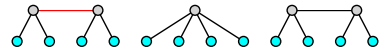

BlowUpGraph; Excess: [1, 1, 1]  g: 8  n: 1   V: 5  E: 11 crossType: B


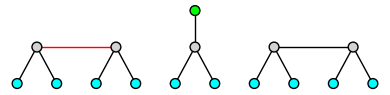

BlowUpGraph; Excess: [1, 1, 1]  g: 10  n: 0   V: 5  E: 13 crossType: A


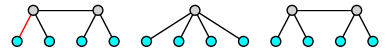

BlowUpGraph; Excess: [1, 1, 1]  g: 8  n: 1   V: 5  E: 11 crossType: A


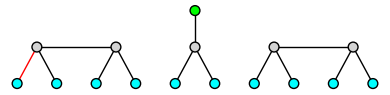

In [87]:
print(blowups[blowups['graph'].apply(lambda G: G.partition == [1,1,1] ) ].groupby(['vertices']).size())
for row in blowups[blowups['graph'].apply(lambda G: G.partition==[1,1,1] and G.vertices==5)].itertuples():
    #break
    row.graph.show(True)

In [84]:
# Generate all (unordered) completions of the collections in blowups by means of appending the excess 0 uncrossed blown up components
# this task is grouped by excess and the possible (g,n) pairs corresponding to the excess
# the pair (g,n) determines uniquely which and how many excess 0 components must be appended to obtain a (g,n)-graph when they are glued to the special vertex
blowups_complete = pd.DataFrame(columns=['excess','partition','comp_ID_set','g','n','vertices','edges','graph','crossType','j_hairs','tripods','eps'])
for blowup in blowups.itertuples():
    #fill in the dataframe a row for every pair (g,n) obtainable with these positive-excess components
    for (g,n) in gn_table[blowup.excess]:
        if g>=blowup.g and n>=blowup.n and (g-blowup.g)%2==0:
            jo_hairs = n-blowup.n
            tripods = ((g-blowup.g)/2)
            if 11==3*tripods+blowup.graph.ome+jo_hairs:
                components = [OJ_HAIR for x in range(jo_hairs)] + [TRIPOD for x in range(tripods)]
                components = components + blowup.graph.components
                G = BlowUpGraph(components)
                blowups_complete.loc[len(blowups_complete)] = {'graph':G,'comp_ID_set':blowup.comp_ID_set,'excess':blowup.excess,'partition':blowup.partition,'g':g,'n':n,'vertices':G.vertices,'edges':G.edges,'j_hairs':jo_hairs,'tripods':tripods,'crossType':G.crossed.crossType,'eps':G.eps}

blowups_complete.sort_values(by=['excess','n','g','edges'], inplace=True)
print("blowups_complete size: ")
print(blowups_complete.groupby(['excess','g','n']).size())

blowups_complete size: 
excess  g  n 
0       3  8       1
        5  5       1
        7  2       1
1       2  10      2
        4  7       5
        6  4       5
        8  1       5
2       1  12      1
        3  9      10
        5  6      26
        7  3      32
        9  0      19
3       2  11     13
        4  8      59
        6  5     124
        8  2     155
4       1  13      5
        3  10     80
        5  7     301
        7  4     565
        9  1     503
dtype: int64


In [85]:
def blowups_A3():
    return blowups_complete[blowups_complete['graph'].apply(lambda G: G.crossed.crossType=='A' and G.crossed.A3case)]
def blowups_A2(eps=None):
    return blowups_complete[blowups_complete['graph'].apply(lambda G: G.crossed.crossType=='A' and (not G.crossed.A3case) and (eps==None or G.eps==eps))]
def blowups_B1(eps=None):
    return blowups_complete[blowups_complete['graph'].apply(lambda G: G.crossed.crossType=='B' and G.crossed.B1case and (eps==None or G.eps==eps))]
def blowups_Birr():
    return blowups_complete[blowups_complete['graph'].apply(lambda G: G.crossed.crossType=='B' and (not G.crossed.B1case))]

grouped_blowups =blowups_B1(1).groupby(['g','n','edges'])
for excess in range(0,MAX_EXCESS+1):
    print(f"EXCESS {excess} GRAPHS:")
    for (g,n) in gn_table[excess]:
        for edges in range(20):
            if (g,n,edges) in grouped_blowups.groups.keys():
                print(f'(g,n): ({g},{n}), edges: {edges}')
                for G in grouped_blowups.get_group((g,n,edges)).itertuples():
                    break
                    #print(G.graph)
                    G.graph.show()

EXCESS 0 GRAPHS:
EXCESS 1 GRAPHS:
EXCESS 2 GRAPHS:
(g,n): (5,6), edges: 12
(g,n): (7,3), edges: 12
(g,n): (9,0), edges: 12
EXCESS 3 GRAPHS:
(g,n): (4,8), edges: 12
(g,n): (6,5), edges: 12
(g,n): (6,5), edges: 13
(g,n): (8,2), edges: 12
(g,n): (8,2), edges: 13
EXCESS 4 GRAPHS:
(g,n): (3,10), edges: 12
(g,n): (5,7), edges: 12
(g,n): (5,7), edges: 13
(g,n): (7,4), edges: 12
(g,n): (7,4), edges: 13
(g,n): (7,4), edges: 14
(g,n): (9,1), edges: 12
(g,n): (9,1), edges: 13
(g,n): (9,1), edges: 14


In [ ]:
class Relation11Group:
    def __init__(self):
        self.blowupgraphs = []

    def check_compatibility(self,blowupgraph):
        if len(self.blowupgraphs)==0: return True
        elif self.g==blowupgraph.g and self.n==blowupgraph.n and self.eps==blowupgraph.eps:
            

            return True
        return False

    def try_add(self,blowupgraph):
        #check if blowupgraph is compatible with the group
        if len(self.blowupgraphs)==0:
            self.blowupgraphs.append(blowupgraph)
            self.components0 = blowupgraph.components
            self.crossed0 = blowupgraph.crossed
            self.g = blowupgraph.g
            self.n = blowupgraph.n
            self.eps = blowupgraph.eps
            return True
        else:
            if self.check_compatibility(blowupgraph):
                self.blowupgraphs.append(blowupgraph)
                return True
            else:
                return False
    def __str__(self):
        return self.blowupgraph.__str__()
    